In [0]:
#basic interface of flow nets
import torch

class FlowModule(torch.nn.Module):
  """Abstract module for normalizing flows.
  
  Methods:
    forward(x): Performs inference of the latent variable conditioned on the input x. Returns the value of the latent variable y, as well as the logarithm of the absolute value of the determinant of the Jacobian.
    inverse(y): Acts in the opposite direction to the forward method and is for sampling x values.
    
  """
  
  def __init__(self, *args):
    super(FlowModule, self).__init__()

  def inverse(self, y):
    raise NotImplementedError

class FlowStack(torch.nn.Sequential, FlowModule):
  """A FlowModule that is created by stacking multiple FlowModules.
  
  Args: Individual FlowModules must be listed in the order from x-space (data) to y-space (latent variable).
  
  """
  
  def __init__(self, *args):
    for net in args:
      assert(isinstance(net, FlowModule))
    super(FlowStack, self).__init__(*args)
    
  def forward(self, x):
    log_abs_det = 0.
    for module in self._modules.values():
      x, delta = module(x)
      log_abs_det += delta
    return x, log_abs_det
  
  def inverse(self, y):
    for module in reversed(self._modules.values()):
      y = module.inverse(y)
    return y
    
class FlowGenerator(torch.nn.Module):
  """Generative model created from a FlowModule and a distribution over the latent variable.
  
  Args:
    net(FlowModule): The module representing the normalizing flow.
    prior(torch.distributions.distribution.Distribution): The distribution over the latent variable y.
  
  Methods:
    forward(n): Creates n samples.
    log_p(x): Calculates the model probability for a sample x.
    crossentropy_loss(x): Returns a loss tensor suitable for training the model, based on the monte-carlo estimate of the crossentropy between data generating distribution and model distribution. Minimizing this is equivalent to minimizing the KL-divergence between aggregate posterior and prior distributions of the latent variable.
    
  """

  def __init__(self, net, prior):
    assert(isinstance(net, FlowModule))
    assert(isinstance(prior, torch.distributions.distribution.Distribution))
    super(FlowGenerator, self).__init__()
    self._net = net
    self._prior = prior
    
  def forward(self, n):
    y = self._prior.sample(torch.Size([n]))
    y = self._net.inverse(y)
    return y

  def log_p(self, x):
    y, log_abs_det = self._net(x)
    return prior.log_prob(y) + log_abs_det
  
  def crossentropy_loss(self, x):
    return -1. * (self.log_p(x)).mean()

In [0]:
#coupling layer from realNVP paper
import torch

class CouplingLayer(FlowModule):
  
  def __init__(self, s, t, mask):
    assert(isinstance(s, torch.nn.Module))
    assert(isinstance(t, torch.nn.Module))
    assert(isinstance(mask, torch.ByteTensor))
    super(CouplingLayer, self).__init__()
    self._s = s
    self._t = t
    self.register_buffer("mask", mask)
    
  def forward(self, x):
    x_ = torch.where(self.mask, x, torch.zeros_like(x))
    scale = torch.where(~self.mask, self._s(x_), torch.zeros_like(x_))
    trans = torch.where(~self.mask, self._t(x_), torch.zeros_like(x_))
    x = torch.where(~self.mask, x * torch.exp(scale) + trans, x_)
    log_det = scale.sum(dim=1)
    return x, log_det
  
  def inverse(self, y):
    y_ = torch.where(self.mask, y, torch.zeros_like(y))
    scale = torch.where(~self.mask, self._s(y_), torch.zeros_like(y_))
    trans = torch.where(~self.mask, self._t(y_), torch.zeros_like(y_))
    y = torch.where(~self.mask, (y - trans) * torch.exp(-1. * scale), y_)
    return y

In [0]:
#helper functions for initialization of (stacks of) coupling layers
import torch

def create_mask(n, p=0.5):
  idx = torch.randperm(n).byte()
  mask = torch.where(idx > p * (n - 1), torch.ones_like(idx), torch.zeros_like(idx))
  return mask

def create_t(n, h=[256,256]):
  net = torch.nn.Linear(n, h[0])
  for layer in range(1, len(h)):
    net = torch.nn.Sequential(net, torch.nn.LeakyReLU(), torch.nn.Linear(h[layer-1], h[layer]))
  net = torch.nn.Sequential(net, torch.nn.LeakyReLU(), torch.nn.Linear(h[-1], n))
  return net

def create_s(n, h=[256,256]):
  net = create_t(n, h)
  net = torch.nn.Sequential(net, torch.nn.Tanh())
  return net
  
def create_2cl(n, p=0.5, ht=[256,256], hs=[256,256]):
  mask = create_mask(n, p)
  t1 = create_t(n, ht)
  t2 = create_t(n, ht)
  s1 = create_s(n, hs)
  s2 = create_s(n, hs)
  cl1 = CouplingLayer(s1, t1, mask)
  cl2 = CouplingLayer(s2, t2, ~mask)
  return FlowStack(cl1, cl2)

def create_flownet(n, d=3, p=None, ht=None, hs=None):
  if p is None: p = [0.5] * d
  if ht is None: ht = [[256,256]] * d
  if hs is None: hs = [[256,256]] * d
  assert(len(p) == len(ht) == len(hs) == d)
  net = create_2cl(n, p[0], ht[0], hs[0])
  for i in range(1, d):
    net = FlowStack(net, create_2cl(n, p[i], ht[i], hs[i]))
  return net

In [4]:
#main cell
device = torch.device("cuda")
n = 2
mynet = create_flownet(n)
prior = torch.distributions.MultivariateNormal(torch.zeros(n).to(device), torch.eye(n).to(device))
mygen = FlowGenerator(mynet, prior).to(device)
optimizer = torch.optim.Adam(mygen.parameters())
batches = 5000
batchsize = 100

import sklearn.datasets
import numpy

for t in range(batches):
  noisy_moons = torch.from_numpy(sklearn.datasets.make_moons(n_samples=batchsize, noise=0.05)[0].astype(numpy.float32)).to(device)
  #we need noise because data distribution needs to be smooth enough for our model to fit
  loss = mygen.crossentropy_loss(noisy_moons)
  optimizer.zero_grad()
  loss.backward()
  if (t%500 == 0):
    print(t, loss.item())
  optimizer.step()

0 2.6472809314727783
500 0.7664527893066406
1000 0.7504106163978577
1500 0.5837680101394653
2000 0.5812960863113403
2500 0.7107260227203369
3000 0.4661661684513092
3500 0.4415769875049591
4000 0.6490533947944641
4500 0.5454936027526855


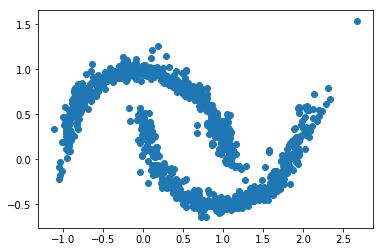

In [5]:
import matplotlib.pyplot as plt

x = mygen(1000).detach().cpu().numpy()
plt.scatter(x[:,0], x[:,1])